In [1]:
import sys
sys.path.append('../modules')

from operators import *
from preprocessing import *
from eof import *
from gridding import *
from mapper import *
from scipy.stats import linregress

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature
import seaborn as sns
sns.set_palette("RdGy")

import pandas as pd

%load_ext autoreload
%autoreload 2

## Snowload
---
Load data and interpolate the design value field

In [36]:
PATH = '/storage/data/projects/nrc/CanRCM4_large_ensemble/design_values/snw/snw_CanRCM4-LE_ens35_1951-2016_max_rl50_load.nc'
mask_path = '/storage/home/nannau/mask.nc'
dv = 'snw'

interp_dict = get_interpolation(mask_path, PATH, dv)
# master_idx = interp_dict['idx']
midx = interp_dict['idx']

#north_master_idx = interp_dict['irlat_ens'] > -10.

In [30]:
#midx = np.logical_and(north_master_idx, master_idx)
midx

array([False, False, False, ..., False, False, False])

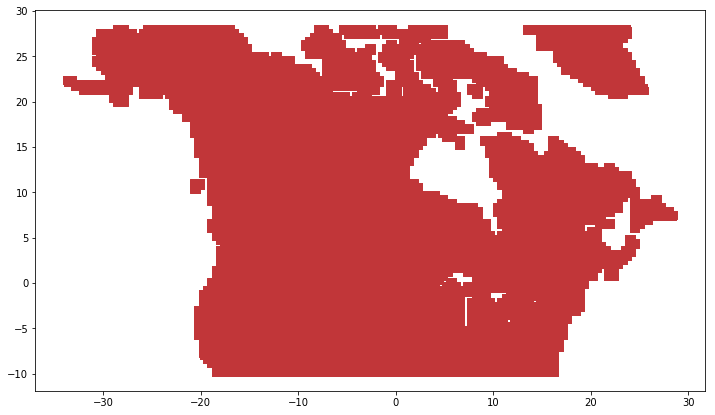

In [31]:
iens = interp_dict['iens'][:, midx].T
oldiens = iens.copy()

plt.figure(figsize=(12,7))
plt.scatter(interp_dict['irlon_ens'][midx], interp_dict['irlat_ens'][midx], marker='s')

Text(0.5, 1.0, 'KDE Distribution of snw Values')

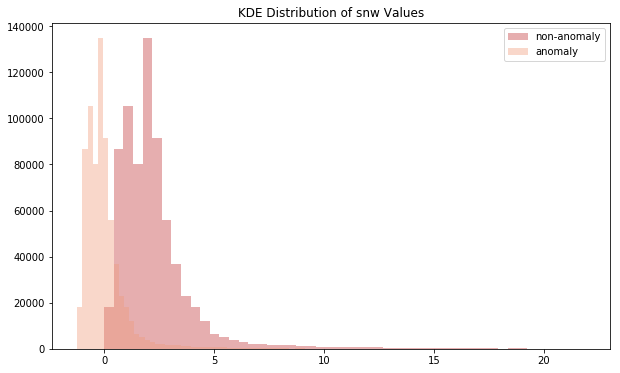

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
iens = scaler.fit_transform(iens)

plt.figure(figsize=(10, 6))
sns.distplot(oldiens[..., 0], kde = False, kde_kws = {'shade': True,'linewidth': 3}, label='non-anomaly')
sns.distplot(iens[..., 0], kde = False, kde_kws = {'shade': True,'linewidth': 3}, label='anomaly')
plt.legend()
plt.title('KDE Distribution of {} Values'.format(dv))

Perform singular value decomposition

In [33]:
u, s, vT = np.linalg.svd(iens.T, full_matrices=False)
explained_variance_ratio = [s[i]/np.sum(s) for i in range(s.shape[0])]

del u

Transform back into the spatial representation

In [34]:
iens_copy = np.full_like(np.zeros(interp_dict['iens'].shape), np.nan)
iens_copy[:, midx] = vT

X = np.reshape(iens_copy, (iens_copy.shape[0], interp_dict['irlat'].shape[0], interp_dict['irlon'].shape[0]))

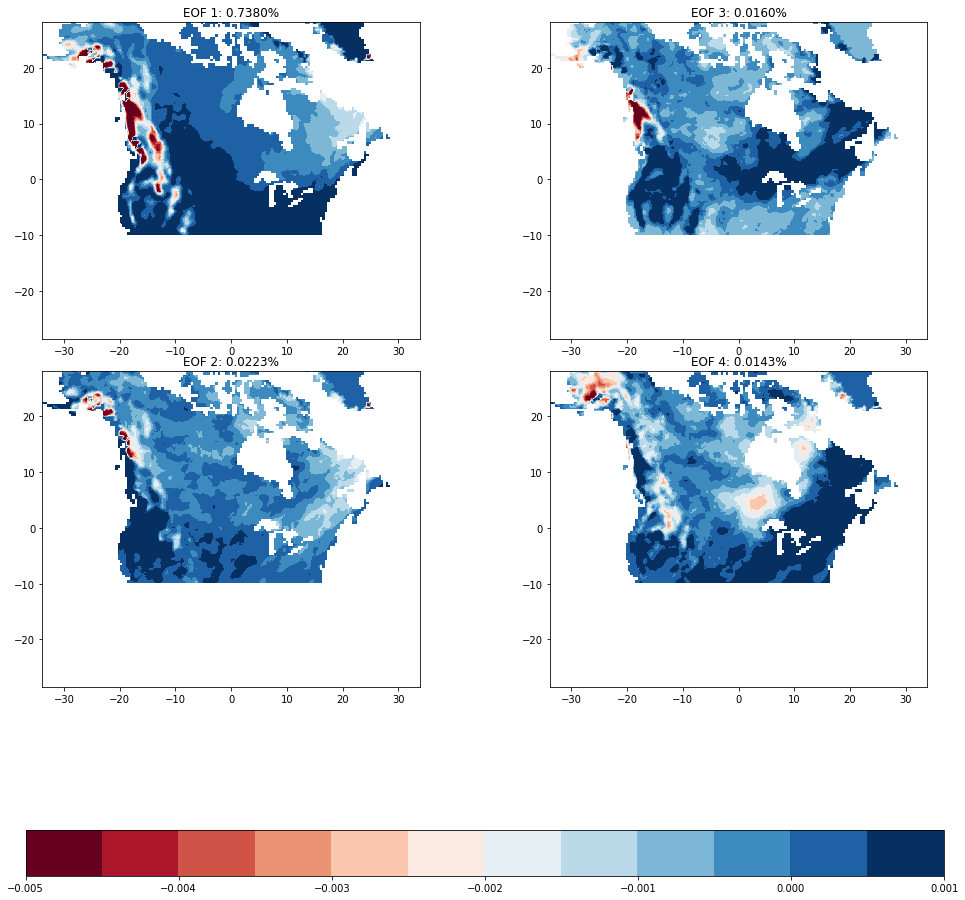

In [35]:
vmin, vmax = -0.005, 0.001

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
x, y = interp_dict['irlon'], interp_dict['irlat']
eof1 = axes[0, 0].imshow(X[0, ...], origin='lower', cmap=plt.cm.get_cmap('RdBu', 12), label='EOF', vmin=vmin, vmax=vmax, extent=[x.min(), x.max(), y.min(), y.max()])
axes[0, 0].set_title('EOF 1: {0:.4f}%'.format(explained_variance_ratio[0]))
axes[1, 0].imshow(X[1, ...], origin='lower', cmap=plt.cm.get_cmap('RdBu', 12), label='EOF', vmin=vmin, vmax=vmax, extent=[x.min(), x.max(), y.min(), y.max()])
axes[1, 0].set_title('EOF 2: {0:.4f}%'.format(explained_variance_ratio[1]))
axes[0, 1].imshow(X[2, ...], origin='lower', cmap=plt.cm.get_cmap('RdBu', 12), label='EOF', vmin=vmin, vmax=vmax, extent=[x.min(), x.max(), y.min(), y.max()])
axes[0, 1].set_title('EOF 3: {0:.4f}%'.format(explained_variance_ratio[2]))
axes[1, 1].imshow(X[3, ...], origin='lower', cmap=plt.cm.get_cmap('RdBu', 12), label='EOF', vmin=vmin, vmax=vmax, extent=[x.min(), x.max(), y.min(), y.max()])
axes[1, 1].set_title('EOF 4: {0:.4f}%'.format(explained_variance_ratio[3]))
plt.tight_layout(pad=6.5)
plt.colorbar(eof1, ax=axes.ravel().tolist(), orientation='horizontal')
# plt.set_xlim(x.min(), x.max())